In [1]:
!pip install torch

In [2]:
import torch
import torch.nn as nn
import numpy as np

In [3]:
save_dir = "diffusion training data/"
def load_transitions():
    import os.path
    if not os.path.isfile(save_dir + "observations.npz"):
        print("No saved transitions found")
        return()
    #its stored as a dict so grab out the single array. and 0th axis should be the number of transitions
    observations = np.load(save_dir + "observations.npz")["arr_0"]
    actions = np.load(save_dir + "actions.npz")["arr_0"]
    rewards = np.load(save_dir + "rewards.npz")["arr_0"]
    dones = np.load(save_dir + "dones.npz")["arr_0"]
    assert(len(observations) == len(actions) == len(rewards) == len(dones))
    print("loaded transitions of length", len(observations))
    
    

    return observations, actions, rewards, dones

In [7]:
observations, actions, rewards, dones = load_transitions()
print(observations[0].size, actions[0].size, rewards[0].size, dones[0].size)

loaded transitions of length 15280
33600 1 1 1


In [ ]:
class MyNetwork(nn.Module):
    def __init__(self):
        super(MyNetwork, self).__init__()
        self.fc1 = nn.Linear(in_features=input_size, out_features=hidden_size)
        self.fc2 = nn.Linear(in_features=hidden_size, out_features=output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Define the input, hidden, and output sizes
input_size = 2 * observations[0].size + actions[0].size() #two screens of pong and the action taken on the last frame
hidden_size = 100 #arbitrary
output_size = observations[0].size + rewards[0].size() #one screen of pong + the reward

# Create an instance of the network
net = MyNetwork()


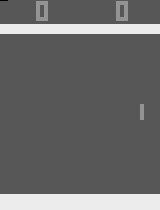

In [12]:
from PIL import Image
image = Image.fromarray(observations[0])
image.show()

In [13]:
gif = []
images = [Image.fromarray(observation) for observation in observations]
for image in images:
    gif.append(image)
gif[0].save('temp/result.gif', save_all=True,optimize=False, append_images=gif[1:], loop=0)